Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle

import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
path = "../"
category = "balanced_data"
# category = "imbalanced_data"
# category = "real_data"



In [3]:
# sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
# sczi.mean()

In [4]:
for category in [ "real_data", "imbalanced_data", "balanced_data",]:

    df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline.pkl")
#     df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari_0"].mean().unstack(["layers", "lr"])

    df_k = df[[
        'dataset',
        'dropout',
        'kmeans_ari_0',
        'kmeans_nmi_0',
        'kmeans_sil_0',
        'kmeans_cal_0',
        'run',
        "time",
        'kmeans_pred_0',
    ]].rename(columns={
        'kmeans_ari_0': "ARI",
        'kmeans_nmi_0': "NMI",
        'kmeans_pred_0': 'pred',
        'kmeans_sil_0': "sil",
        'kmeans_cal_0': "cal",
    })
    df_k["method"] = "constrastive+KM"

    df_l = df[[
        'dataset',
        'dropout',
        'leiden_ari_0',
        'leiden_nmi_0',
        'leiden_sil_0',
        'leiden_cal_0',
        'run',
        'time',
        'leiden_pred_0',
    ]].rename(columns={
        'leiden_ari_0': "ARI",
        'leiden_nmi_0': "NMI",
        'leiden_pred_0': 'pred',
        'leiden_sil_0': "sil",
        'leiden_cal_0': "cal",
    })

    df_l["method"] = "constrastive+LD"

    r_data = pd.read_pickle(f"../R/{category}.pkl")

    scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
    scDeepCluster["method"] = "scDeepCluster"

    sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
    sczi["method"] = "scziDesk"

    scedar = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scedar.pkl")
    scedar["method"] = "scedar"

    scanpy = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scanpy.pkl")
    scanpy["method"] = "scanpy-seurat"

    scrna = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scrna.pkl")
    scrna["method"] = "scrna"

    pca_kmeans = pd.read_pickle(f"../output/pickle_results/{category}/{category}_pca_kmeans.pkl")
    pca_kmeans["method"] = "pca_kmeans"

    desc = pd.read_pickle(f"../output/pickle_results/{category}/{category}_desc.pkl")
    desc["pred"] = desc["pred"].apply(lambda x: x.to_list())
    desc["method"] = "desc"

    all_data = pd.concat([df_k, df_l, r_data, desc,pca_kmeans, sczi, 
                          scDeepCluster ,scedar, scanpy, scrna])
    all_data = all_data.reset_index(drop = True)

#     all_data["Silhouette"] = np.nan
#     all_data["Calinski"] = np.nan
    all_data = all_data.rename(columns={"sil": "Silhouette", "cal": "Calinski"})

    path = ".."
    if category in ["balanced_data", "imbalanced_data"]:
        files = glob2.glob(f'{path}/R/simulated_data/{category}/*.h5')
        files = [f[len(f"{path}/R/simulated_data/{category}/"):-3] for f in files]
    else:
        files = glob2.glob(f'{path}/real_data/*.h5')
        files = [f[len(f"{path}/real_data/"):-3] for f in files]
    print(files)

#     for dataset in tqdm(files):
#         if category in ["balanced_data", "imbalanced_data"]:
#             data_mat = h5py.File(
#                 f"{path}/R/simulated_data/{category}/{dataset}.h5", "r")
#         else:
#             data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

#         Y = np.array(data_mat['Y'])
#         X = np.array(data_mat['X'])
#         X = train.preprocess(X, nb_genes=500)
#         X = PCA(n_components=5).fit_transform(X)

#         ss = [
#             silhouette_score(X, predi) if predi is not None else None
#             for predi in all_data[all_data["dataset"] == dataset]["pred"].values
#         ]
#         all_data.loc[all_data[all_data["dataset"] == dataset].index.values,
#                      "Silhouette"] = ss
#         ss = [
#             calinski_harabasz_score(X, predi) if predi is not None else None
#             for predi in all_data[all_data["dataset"] == dataset]["pred"].values
#         ]
#         all_data.loc[all_data[all_data["dataset"] == dataset].index.values,
#                      "Calinski"] = ss
#     all_data["Silhouette"] = all_data.apply(
#         lambda x: x["Silhouette"] if (pd.isnull(x["sil"]) or x["method"] in
#                                       ["scDeepCluster", "scziDesk"]) else x["sil"],
#         axis=1)
#     all_data["Calinski"] = all_data.apply(
#         lambda x: x["Calinski"] if (pd.isnull(x["cal"]) or x["method"] in
#                                       ["scDeepCluster", "scziDesk"]) else x["cal"],
#         axis=1)

    if category in ["imbalanced_data", "balanced_data"]:
        sc_dropout = {
            'data_1c8': 0.3,
            'data_-1c4': 0.08,
            'data_-1c8': 0.08,
            'data_0c4': 0.17,
            'data_0c8': 0.17,
            'data_0c16': 0.17,
            'data_1.5c4': 0.38,
            'data_1c4': 0.3,
            'data_1.5c8': 0.38,
            'data_1.5c16': 0.38,
            'data_-1c16': 0.08,
            'data_1c16': 0.3,
            'data_0c32': 0.17,
            'data_1.5c32': 0.38,
            'data_1c32': 0.3,
            'data_-1c32': 0.08
        }
        all_data["dropout"] = all_data["dataset"].apply(lambda x: sc_dropout[x])
        all_data["nb_clust"]= all_data["dataset"].apply(lambda x: int(x.split("c")[1]))

    ordered_methods = [
        'constrastive+KM',
        'constrastive+LD',
        'scziDesk',
        'scDeepCluster',
        'desc',
        'scanpy-seurat',
        'scedar',
        'scrna',
        'soup',
        'simlr',
        'raceid',
        'cidr',
        'pca_kmeans',
    ]
    ordered_methods = dict(zip(ordered_methods, np.arange(len(ordered_methods))))

    all_data["order"] = all_data["method"].apply(lambda x: ordered_methods[x])

    all_data.to_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm', 'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam', 'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung', 'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell', 'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC']
['data_1c8', 'data_-1c4', 'data_-1c8', 'data_0c4', 'data_0c8', 'data_0c16', 'data_1.5c4', 'data_1c4', 'data_1.5c8', 'data_1.5c16', 'data_-1c16', 'data_1c16']
['data_1c8', 'data_-1c4', 'data_-1c8', 'data_0c4', 'data_0c8', 'data_0c16', 'data_1.5c4', 'data_1c4', 'data_1.5c8', 'data_1.5c16', 'data_-1c16', 'data_1c16']


In [ ]:
# category = "imbalanced_data"
category = "balanced_data"
# category = "real_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [ ]:
# all_data[all_data["method"] == "desc"]

In [5]:
import seaborn as sns

clrs = ['#C0392B', "#F1948A", "#D7BDE2", "#8E44AD", "#7FB3D5", "#2874A6", "#76D7C4", "#117A65",
        "#A9DFBF", "#F1C40F", "#EB984E", "#839192", "#566573"
       ]
len(clrs)

13

# Overall Comparaision

In [ ]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(141)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(a) ARI")
plt.xlabel("")
sns.despine()

ax = plt.subplot(142)
sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.xlabel("")
plt.title("(b) NMI")

ax = plt.subplot(143)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(c) Silhouette")
plt.xlabel("")
sns.despine()

ax = plt.subplot(144)
sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(d) Calinski")
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_barplot.pdf", bbox_inches='tight')

In [ ]:
titles = ["(a)", "(b)", "(c)", "(d)"]
plt.figure(figsize = (12, 12))
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

for i, dropout in enumerate(sorted(all_data.dropout.unique())):
    ax = plt.subplot(4, 2, i+1)
    sns.barplot(x = "nb_clust", y="ARI", 
                data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)

    plt.title(f"{titles[i]} Balanced data, dropout rate {dropout} %")
    if i ==1:
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
#         plt.legend(bbox_to_anchor=(0., 1.4), loc=2, borderaxespad=0., ncol=7)
    else: 
        plt.legend([],[], frameon=False)

    plt.xlabel("")
    sns.despine()
    
    
category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
titles = ["(e)", "(f)", "(g)", "(g)"]
for i, dropout in enumerate(sorted(all_data.dropout.unique())):
    ax = plt.subplot(4, 2, i+5)
    sns.barplot(x = "nb_clust", y="ARI", 
                data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)

    plt.title(f"{titles[i]} Imbalanced data, dropout rate {dropout} %")

    plt.legend([],[], frameon=False)
    if i in [2, 3]:
        plt.xlabel("Nb. of clusters")
    else:
        plt.xlabel("")
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_barplot_by_dropout.pdf", bbox_inches='tight')

In [ ]:
# titles = ["(a)", "(b)", "(c)", "(d)"]
# plt.figure(figsize = (12, 5))
# for i, dropout in enumerate(sorted(all_data.dropout.unique())):
#     ax = plt.subplot(2, 2, i+1)
#     sns.barplot(x = "nb_clust", y="ARI", 
#                 data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
#                 hue = "method",
#                palette=clrs,
#                edgecolor='black',
#         linewidth=1.5)

#     plt.title(f"{titles[i]} dropout rate {dropout} %")
#     if i ==1:
#         plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
#     else: 
#         plt.legend([],[], frameon=False)
#     if i in [2, 3]:
#         plt.xlabel("Nb. of clusters")
#     else:
#         plt.xlabel("")
#     sns.despine()
# # plt.tight_layout()
# plt.savefig(f"../diagrams/{category}_barplot_by_dropout.pdf", bbox_inches='tight')

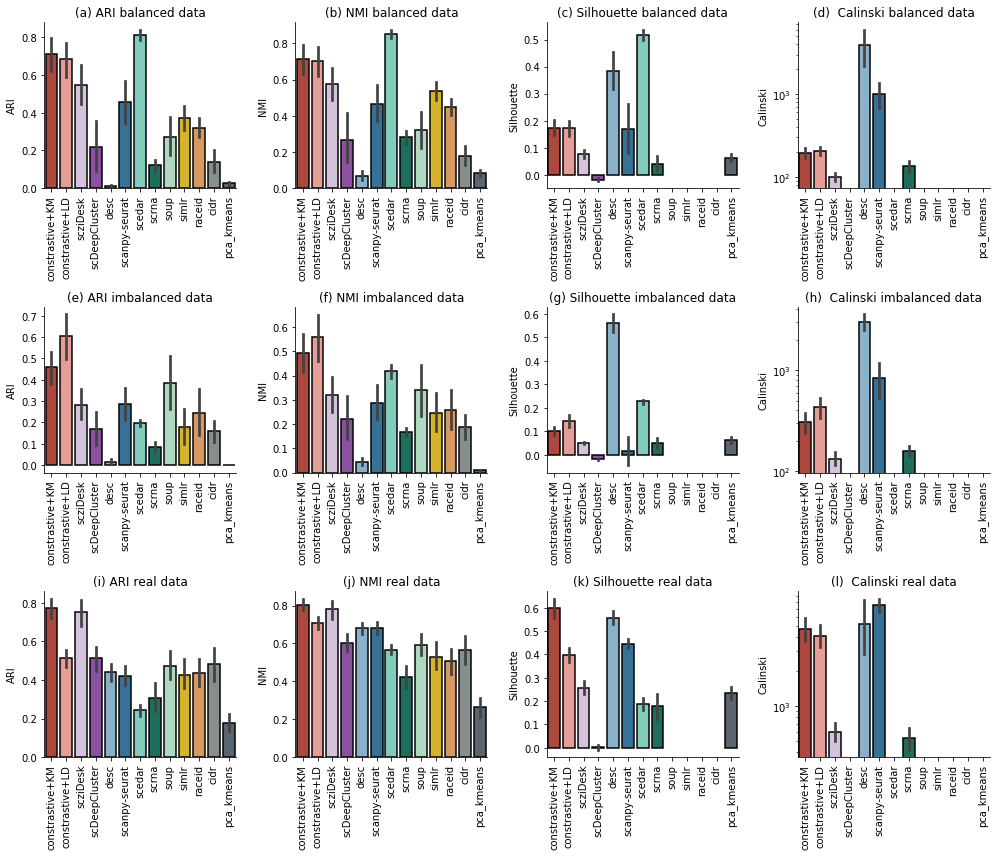

In [6]:
plt.figure(figsize=(14, 12))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["balanced data", "imbalanced data", "real data"]
for i, category in enumerate (["balanced_data", "imbalanced_data", "real_data"] ):
    all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
    
    ax = plt.subplot(3,4,i*4 +1)
    sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4]} ARI {titles[i]}")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +2)
    sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.xlabel("")
    plt.title(f"{letters[i*4 +1]} NMI {titles[i]}")

    ax = plt.subplot(3,4,i*4 +3)
    sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +2]} Silhouette {titles[i]}")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +4)
    g= sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    g.set(yscale="log")
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +3]}  Calinski {titles[i]}")
    plt.xlabel("")
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/all_barplot.pdf", bbox_inches='tight')